# Weight Forecaster MVP V2

## Setup

In [1]:
import sys
toolpath = '/Users/jamieinfinity/Dropbox/Projects/WeightForecaster/weightforecaster/server/src'
sys.path.append(toolpath)

from wtfc_utils import etl_utils as etl

from sqlalchemy import create_engine

import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import altair as alt
from IPython.display import Image

import ipywidgets as widgets
import bqplot as bq


## Gathered Reusable Code

In [219]:
weight_target = 155
weight_target_tol = 1
target_label_color = '#07817D'
target_hit_color = '#1AD6CF'
target_near_color = '#97EDEA'
target_miss_color = '#EEB00C'

label_style = {
    'font-size':'16px', 
    'font-family':'avenir-heavy', 
    'color':'#bbb',
}
value_style = {
    'font-size':'42px', 
    'font-family':'tahoma', 
    'color':'#000',
}
value_style_sm = {
    'font-size':'32px', 
    'font-family':'tahoma', 
    'color':'#000',
}
value_unit_style = {
    'font-size':'22px', 
    'font-family':'avenir-light', 
    'color':'#bbb',
}


def stringify_style(style):
    res=''
    for key in style.keys():
        res = res + key + ':'
        res = res + str(style[key]) + '; '
    return res

def label_html(text, style, text_format=None):
    s = stringify_style(style)
    if text_format=='float':
        v = '<div style="{0}">{1:.1f}</div>'.format(s, text)
    else:
        v = '<div style="{0}">{1}</div>'.format(s, text)
    return widgets.HTML(
        value=v,
        placeholder='',
        description='',
        layout=widgets.Layout(align_self='center')
    )

def panel_forecast_col1(weight):
    label = label_html('TODAY', {**label_style, 'margin-bottom':'15px', 'vertical-align':'top'})
    val_num = label_html(weight, {**value_style, 'margin-bottom':'27px'}, text_format='float')
    val_units = label_html('lb', {**value_unit_style, 'margin-left':'5px', 'margin-bottom':'8px'})
    val = widgets.HBox([val_num, val_units],
        layout=widgets.Layout(align_self='center'))
    col = widgets.VBox(
        [
            label,
            val
        ],
        layout=widgets.Layout(align_self='center')
    )
    return col

def panel_forecast_col2_sub(weight, target, months):
    label = label_html(months, {**label_style, 'margin-bottom':'1px'})
    wgt_num = label_html(weight, {**value_style_sm, 'margin-bottom':'10px'}, text_format='float')
    target_num = label_html(target, {**value_style_sm, 'margin-bottom':'2px', 'color':target_label_color}, text_format='float')
    col = widgets.VBox(
        [
            label,
            wgt_num,
            target_num
        ],
        layout=widgets.Layout(align_self='center', padding='10px')
    )
    return col

def panel_forecast_col2(weight, proj_wgts, targ_wgts):
    tw1 = targ_wgts[0]
    tw2 = targ_wgts[1]
    if weight<(weight_target+weight_target_tol):
        tw1 = weight
        tw2 = weight
    ca = panel_forecast_col2_sub(proj_wgts[0], tw1, '1 MONTH')
    cb = panel_forecast_col2_sub(proj_wgts[1], tw2, '2 MONTHS')
    col = widgets.HBox([ca, cb], layout=widgets.Layout(width='300px', padding='20px'))
    return col

def panel_forecast_col3(weight, proj_wgts, targ_wgts):
    pc = target_miss_color
    pw = [x-weight for x in proj_wgts]
    tw = [x-weight for x in targ_wgts]
    maxw = np.max(np.abs([*pw, *tw]))
    pw = [maxw/30]+pw
    tw = [-maxw/30]+tw
    if weight<(weight_target+weight_target_tol):
        tw = [-maxw/30, -maxw/30, -maxw/30]

    bar1 = bq.Bars(x=[1, 3, 5], y=[pw, tw],  
                   scales={'x': bq.LinearScale(), 'y': bq.LinearScale()}, 
                   default_size=1)
    bar1.type = 'grouped'
    if pw[-1]<tw[-1]:
        pc = target_hit_color
    elif pw[-1]<0:
        pc = target_near_color
    bar1.colors = [pc, target_label_color]
    bar_fig = bq.Figure(marks=[bar1], layout=widgets.Layout(align_self='center', width='200px', height='80px'), fig_margin=dict(top=0, bottom=0, left=0, right=0))
    labels = widgets.HBox([
        label_html('TODAY', {**label_style, 'font-size':'12px', 'margin-right':'30px'}),
        label_html('1MO', {**label_style, 'font-size':'12px', 'margin-right':'35px'}),
        label_html('2MO', {**label_style, 'font-size':'12px', 'margin-right':'10px'})
    ], layout=widgets.Layout(align_self='center', padding='5px'))
    col3 = widgets.VBox([labels, bar_fig], layout=widgets.Layout(align_self='center', padding='10px'))
    return col3

def panel_1(today_date, data_df):
    yesterday = today_date - datetime.timedelta(days = 1)
    df_yest = data_df[data_df.index==pd.to_datetime(yesterday)]

    w_avg_yest = df_yest.w_7day_avg.values[0]
    w_proj_1mo = df_yest.Mv1_0_proj_weight_1mo.values[0]
    w_proj_2mo = df_yest.Mv1_0_proj_weight_2mo.values[0]
    w_targ_1mo = df_yest.Mv1_0_targ_weight_1mo.values[0]
    w_targ_2mo = df_yest.Mv1_0_targ_weight_2mo.values[0]

    col1 = panel_forecast_col1(w_avg_yest)
    col2 = panel_forecast_col2(w_avg_yest, [w_proj_1mo, w_proj_2mo], [w_targ_1mo, w_targ_2mo])
    col3 = panel_forecast_col3(w_avg_yest, [w_proj_1mo, w_proj_2mo], [w_targ_1mo, w_targ_2mo])

    grid = widgets.GridspecLayout(1, 3, width='700px', height='200px')
    grid[0,0] = col1
    grid[0,1] = col2
    grid[0,2] = col3

    return grid

## Load Data

In [221]:
server_dir = '/Users/jamieinfinity/Dropbox/Projects/WeightForecaster/weightforecaster/server/'
db_dir = server_dir + 'db/'
db_name = 'weightforecaster'
db_ext = '.db'
db_file_name = db_dir + db_name + db_ext

engine = create_engine('sqlite:///'+db_file_name)

with engine.connect() as conn, conn.begin():
    db_df = pd.read_sql_table('fitness', conn, index_col='date', parse_dates=['date'])
    
today_offset = 0
today = datetime.date.today() - datetime.timedelta(days = today_offset)
# print(today)

# db_df.tail(8)

## Weight Forecast

In [222]:
panel_1(today, db_df)

GridspecLayout(children=(VBox(children=(HTML(value='<div style="font-size:16px; font-family:avenir-heavy; colo…

## Weight Velocity

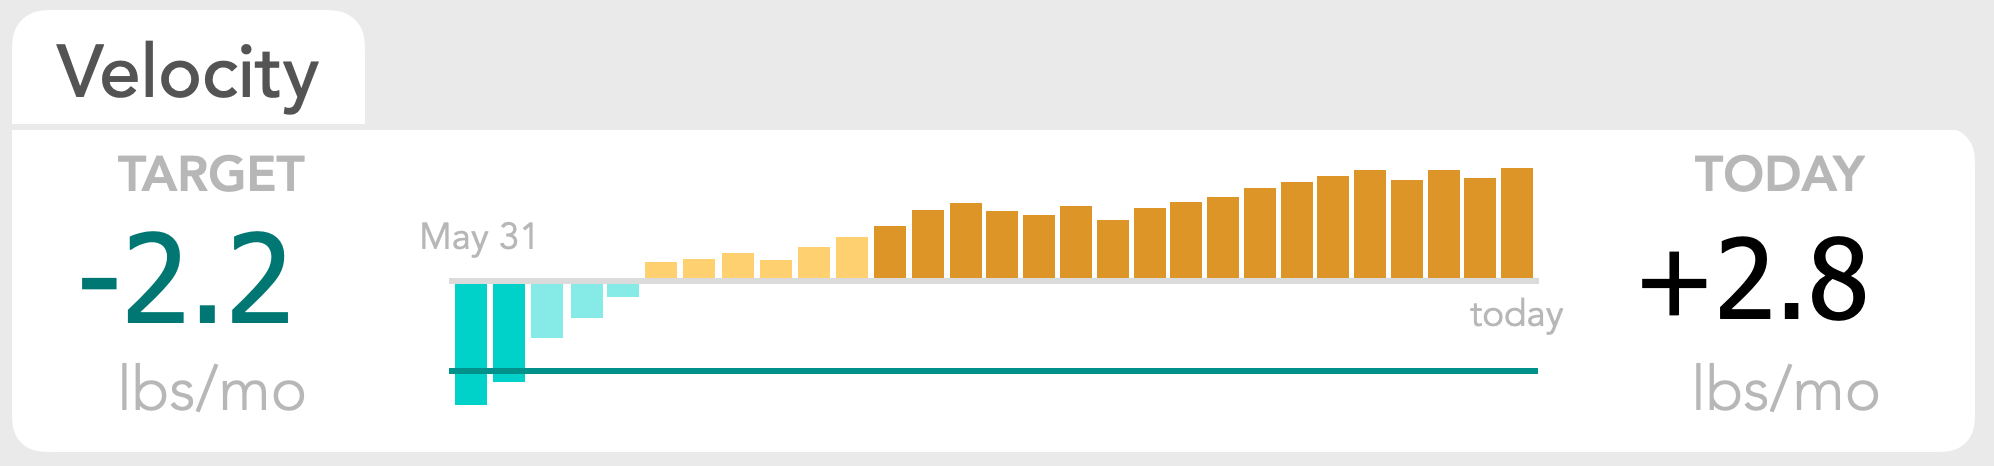

In [15]:
Image(filename='panel_velocity.png', width=600)

## Progress

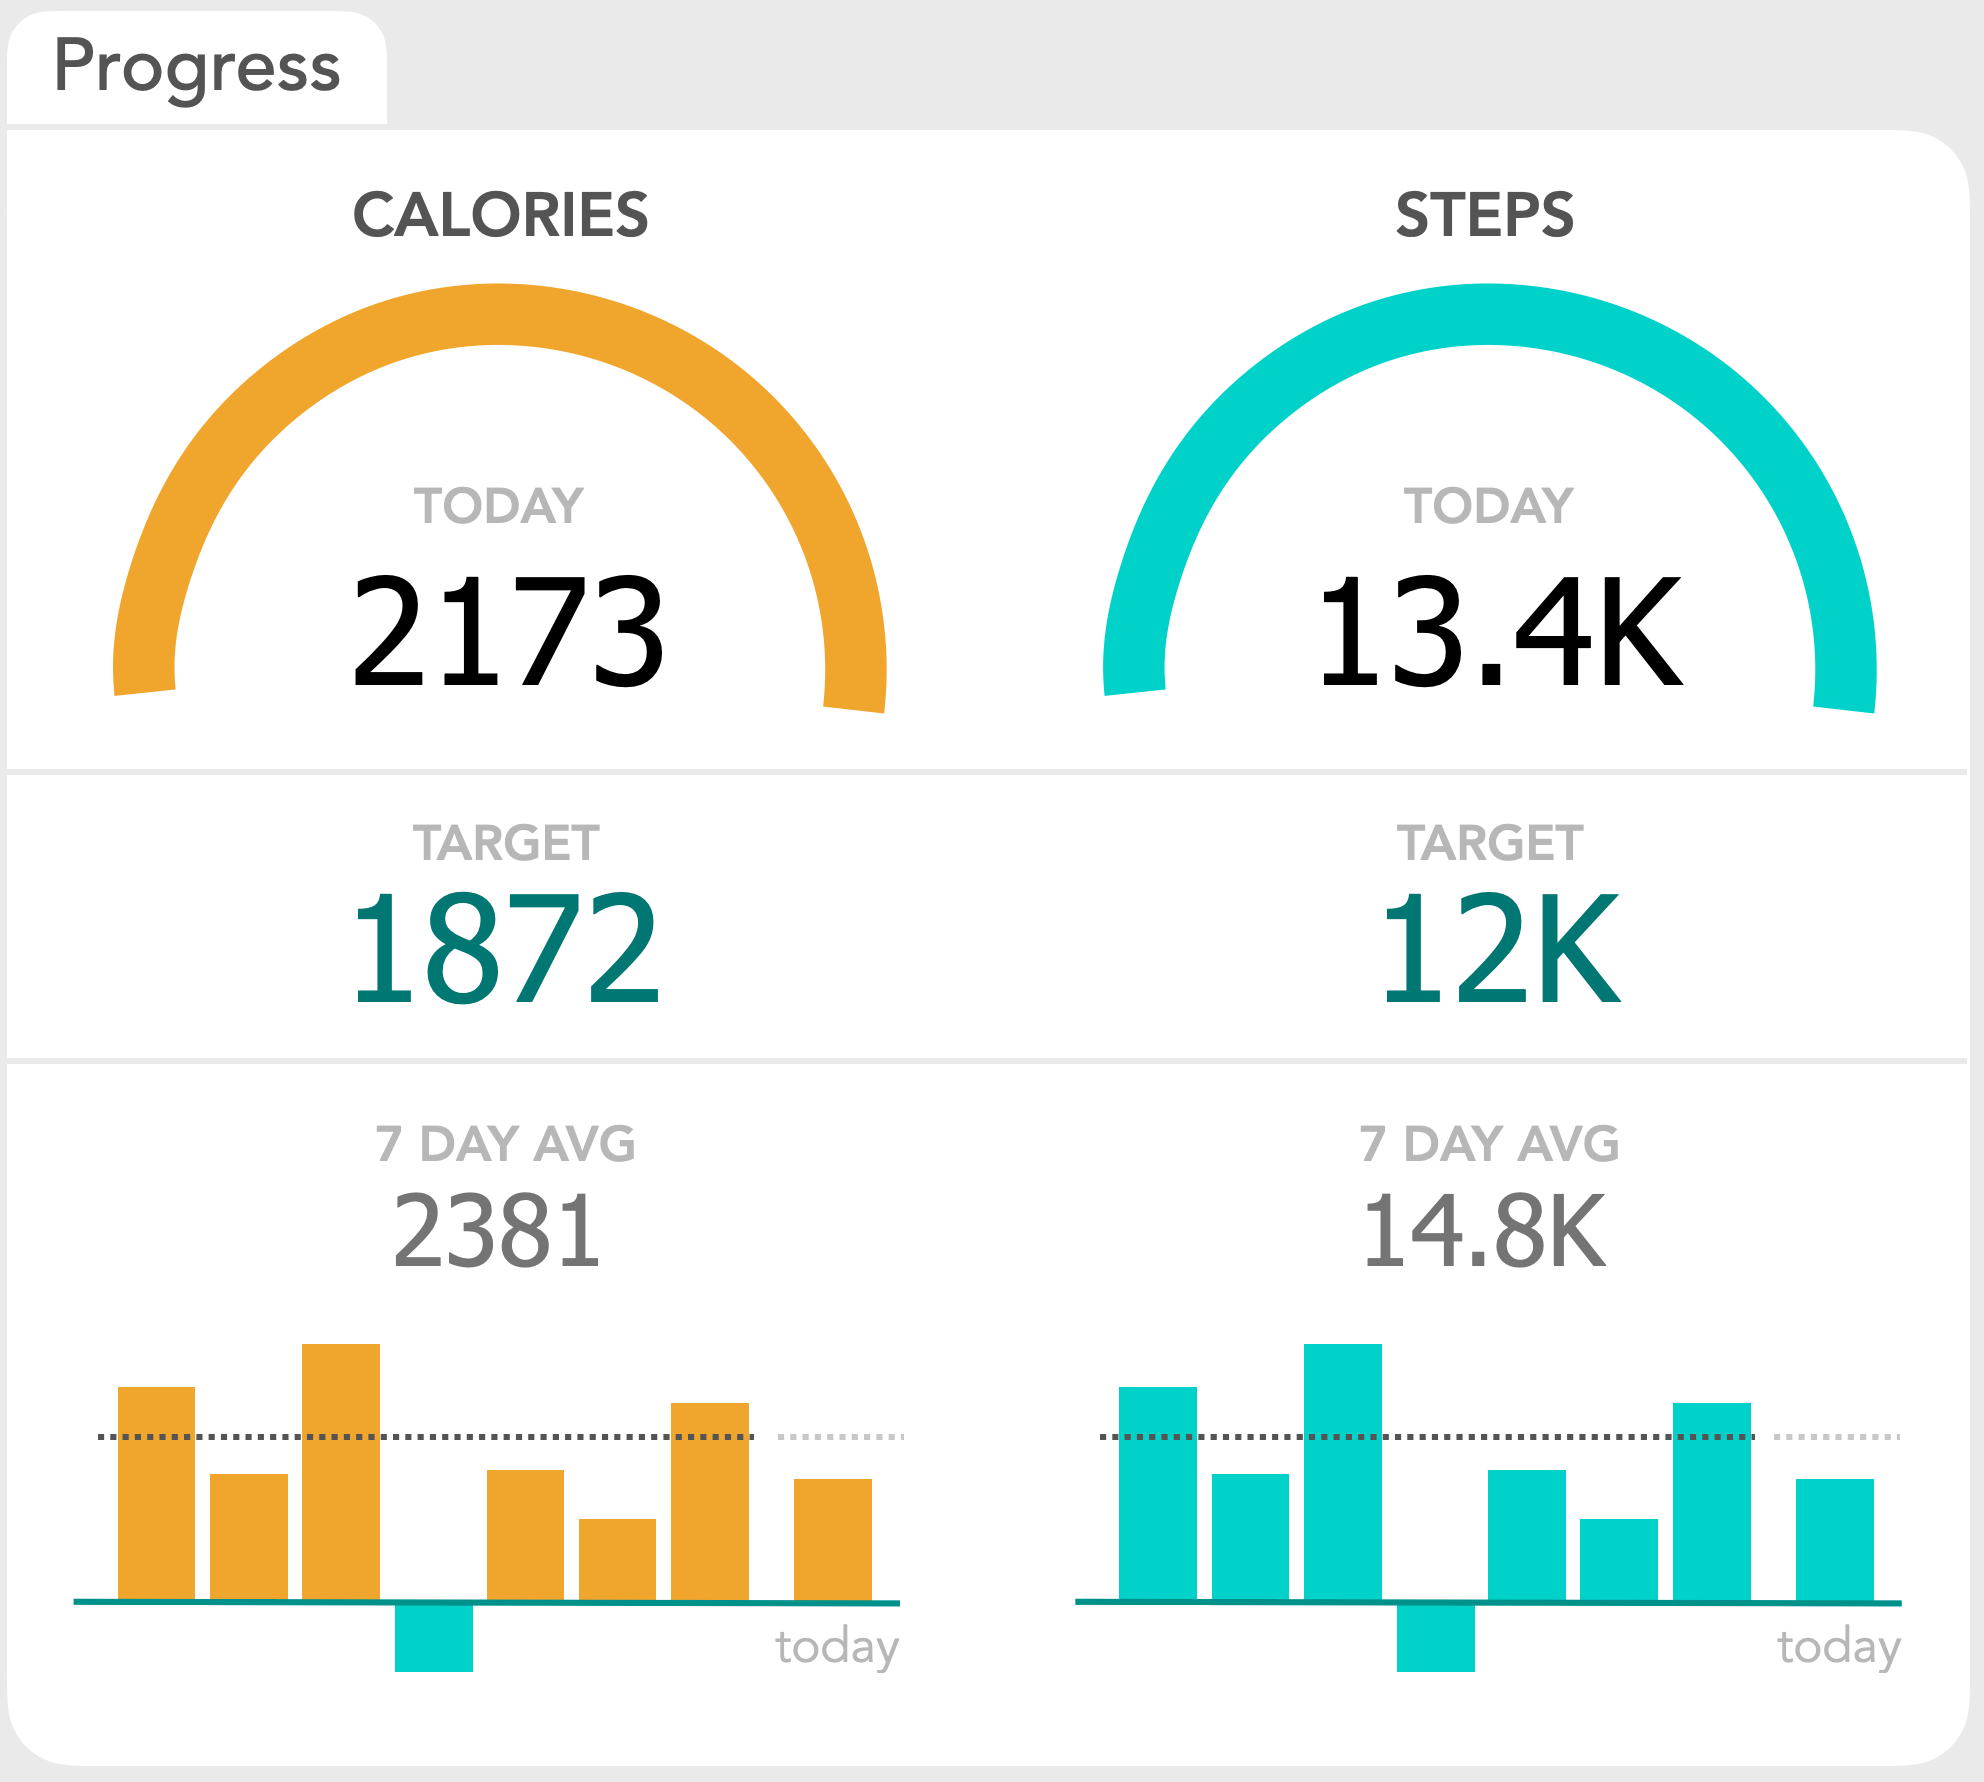

In [16]:
Image(filename='panel_progress.png', width=600)

## History